# Markov Chain Analysis

This notebook tries to find if there are similarities in shopper behaviour using network analysis.

## Load dependencies

In [1]:
import pandas as pd
import numpy as np
import copy

from scipy import stats

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
matplotlib.style.use('ggplot')

import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from msci.utils import utils
from msci.analysis.networks import *
from msci.utils.plot import create_count_of_shoppers_gif, create_count_of_shoppers_image
from msci.utils.plot import plot_path_jn, plot_histogram_jn, plot_points_on_map_jn

In [340]:
from sklearn import preprocessing
from scipy.stats import linregress

## Get data

In [385]:
mac_address_df = utils.import_mac_addresses(version=3)
signal_df = utils.import_signals(version=4)

c:\users\tvb\envs\venv-msci\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [386]:
shopper_df = mac_address_df[mac_address_df.dbscan_label == 'Shopper']

In [549]:
shop_df = utils.import_shop_directory(mall='Mall of Mauritius', version=2)

## Markov Chain

In [550]:
r_signal_df = signal_df[
    signal_df.store_id.notnull() & 
    (signal_df.store_id.str[0] == 'B') & 
    signal_df.mac_address.isin(shopper_df.mac_address)
]

In [551]:
r_signal_mac_address_df = r_signal_df.groupby('mac_address')['store_id'].apply(len)
mac_address_len = r_signal_mac_address_df.as_matrix()

In [552]:
le = preprocessing.LabelEncoder()
le.fit(r_signal_df.sort_values('store_id').store_id.unique())
K = len(le.classes_)
le_Y = le.transform(r_signal_df.sort_values('mac_address').store_id)

onehot = preprocessing.OneHotEncoder()
onehot.fit(le_Y[:, np.newaxis])
onehot_Y = onehot.transform(le_Y[:, np.newaxis])

In [553]:
N = np.zeros((K, K))
N1 = np.zeros(K)

L = len(mac_address_len)

for l in range(L):
    
    seq_start = sum(mac_address_len[:l])
    seq_end = sum(mac_address_len[:l+1])
    
    seq = onehot_Y[seq_start: seq_end].toarray()
    
    T = len(seq)
    
    N1 += seq[0]
        
    if T > 1:
        for t in range(1, T):
            N += np.outer(seq[t-1], seq[t])
        
pi = N1 / N1.sum()
A = (N.T / N.sum(axis=1)).T

In [597]:
val = np.dot(pi, A.dot(A).dot(A).dot(A).dot(A))

store_pi_df = pd.DataFrame(
    np.array([
        le.inverse_transform(range(len(pi))), 
        pi, 
        val / sum(val),
    ]).T, 
    columns=('store_id', 'pi', 'piA')
)

In [598]:
shop_probs_df = pd.merge(shop_df, store_pi_df, on='store_id', how='left')

In [600]:
shop_probs_df.sort_values('piA', ascending=False)

,frequency,store_id,area,dimensions,centroid,x,y,count_of_shoppers,pi,piA
0,138233,B87,3345.833333,"{308.5: [69.0, 92.0], 309.5: [72.5, 104.0], 31...","[318.9785048914996, 89.388654180502002]",318.978505,89.388654,15744,0.177071,0.268587
6,21695,B46,906.000000,"{116.5: [140.5, 142.0], 125.0: [135.0, 150.0],...","[136.18202350772069, 139.51823768917566]",136.182024,139.518238,6318,0.0504935,0.0523028
4,23494,B39,1718.500000,"{18.0: [102.0, 103.0], 19.0: [102.0, 103.0], 2...","[50.058532675009225, 106.37523764932889]",50.058533,106.375238,4711,0.0393619,0.0396287
2,46538,B48,629.000000,"{128.0: [120.0, 131.0], 129.0: [119.0, 121.0],...","[118.1652126577564, 125.09122652456057]",118.165213,125.091227,4464,0.0339683,0.0381924
5,22243,B219,443.333333,"{153.5: [23.0, 28.5], 133.0: [16.0, 16.0], 134...","[158.00708837237184, 24.718982751127694]",158.007088,24.718983,7294,0.044067,0.0360858
3,30784,B251,611.500000,"{256.0: [51.0, 58.0], 256.5: [52.0, 56.5], 258...","[266.81200190575197, 46.96101871101871]",266.812002,46.961019,5449,0.0380996,0.0342561
8,17784,B77,676.000000,"{280.5: [96.5, 107.0], 259.0: [99.0, 99.0], 26...","[270.49156545209178, 103.09851551956815]",270.491565,103.098516,4474,0.0258205,0.0331961
12,12811,B223,319.500000,"{102.5: [23.5, 23.5], 103.5: [23.5, 29.0], 104...","[105.81203653110607, 30.286628678479431]",105.812037,30.286629,5014,0.0288042,0.0284293
1,48621,B247,1214.833333,"{225.0: [56.0, 56.0], 231.33333333333331: [46....","[246.72877631750342, 43.35011277705793]",246.728776,43.350113,6661,0.0290337,0.0256088
15,8704,B45,635.666667,"{153.66666666666666: [155.66666666666666, 155....","[155.94244025735293, 167.24626608455878]",155.942440,167.246266,3055,0.0229516,0.0225107


In [594]:
area_shop_df = shop_probs_df[(shop_probs_df.area > 0) & (shop_probs_df.pi > 0) & (shop_probs_df.count_of_shoppers > 0)]

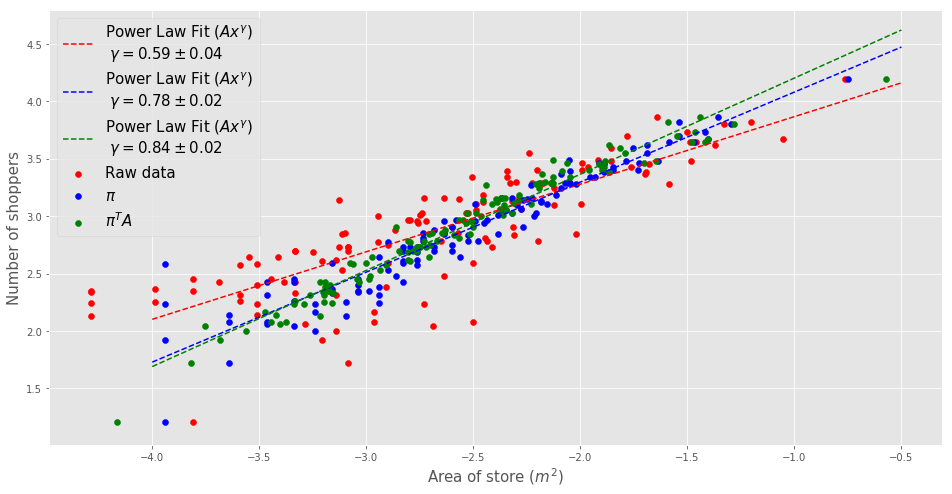

In [595]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))


x = np.log10((area_shop_df.area / sum(area_shop_df.area)).tolist())
y = np.log10(area_shop_df.count_of_shoppers.tolist())
ax.scatter(x, y, c='r', label='Raw data')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(-4), 10**(-0.5), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'r--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.pi.tolist())
y = np.log10(area_shop_df.count_of_shoppers.tolist())
ax.scatter(x, y, c='b', label='$\pi$')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(-4), 10**(-0.5), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'b--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)


x = np.log10(area_shop_df.piA.tolist())
y = np.log10(area_shop_df.count_of_shoppers.tolist())
ax.scatter(x, y, c='g', label='$\pi^T A$')

slope, intercept, x_value, p_value, std_err = linregress(x, y)
x_fit = np.linspace(10**(-4), 10**(-0.5), 10)
y_fit = [10**intercept*x**slope for x in x_fit]
ax.plot(
    np.log10(x_fit), np.log10(y_fit), 
    'g--', 
    label='Power Law Fit ($Ax^{\gamma}$) \n $\gamma=%.2f \pm %.2f$' % (slope, std_err)
)

ax.set_xlabel('Area of store ($m^2$)', fontsize=15)
ax.set_ylabel('Number of shoppers', fontsize=15)
# ax.set_xscale('log')
# ax.set_yscale('log')
ax.legend(fontsize=15)

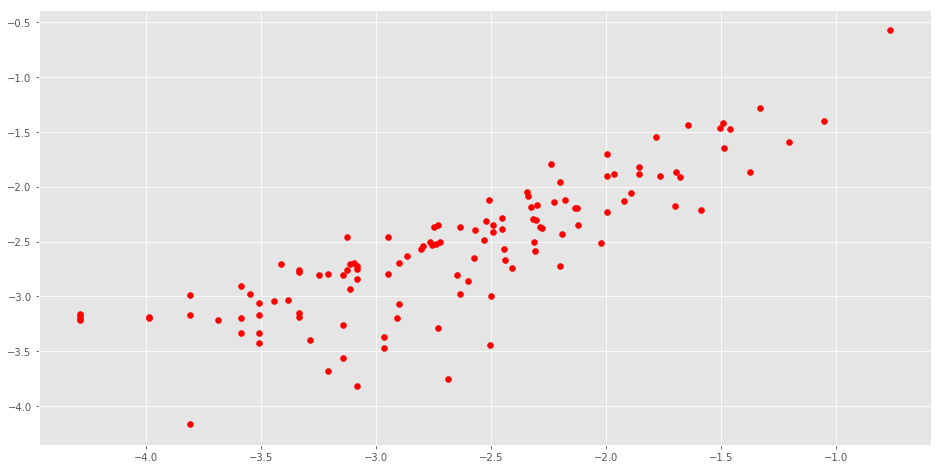

In [590]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))

x = np.log10((area_shop_df.area / sum(area_shop_df.area)).tolist())
y = np.log10(area_shop_df.piA.tolist())
ax.scatter(x, y, c='r', label='Raw data')

In [572]:
le.inverse_transform(5)

'B110'

In [180]:
import networkx as nx

In [303]:
G = nx.from_numpy_matrix(A[:20, :20], create_using=nx.MultiDiGraph())
G = nx.relabel_nodes(G, dict(enumerate(le.inverse_transform(range(len(pi[:20]))))))

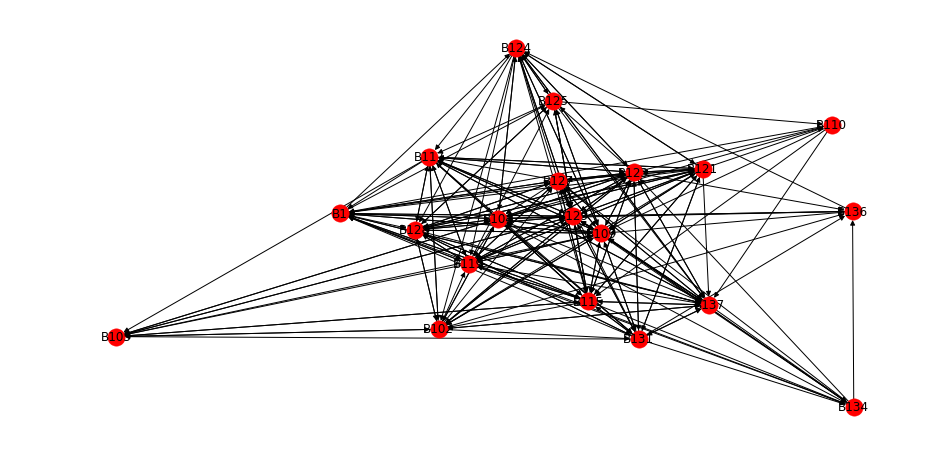

In [304]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
labels = {i : i for i in G.nodes()}
pos=nx.spring_layout(G)
nx.draw(G, pos=pos, ax=ax)
nx.draw_networkx_labels(G, pos=pos, labels=labels);

In [283]:
A[:3, :3]

array([[ 0.3655706 ,  0.        ,  0.001     ],
       [ 0.        ,  0.08757962,  0.0165    ],
       [ 0.00193424,  0.0477707 ,  0.2295    ]])

array([  4.72612383e-03,   4.48238049e-03,   1.51653244e-02,
         1.98243076e-03,   1.42078850e-02,   2.20087469e-04,
         5.52108505e-03,   1.80142639e-03,   1.88177461e-03,
         3.30398550e-03,   3.28728516e-03,   1.07950632e-03,
         6.57431631e-04,   1.65236108e-03,   1.86680085e-03,
         1.22103027e-02,   2.34849890e-03,   6.77352377e-04,
         7.42108308e-04,   2.86067213e-03,   3.68939368e-03,
         5.95095854e-04,   1.09804260e-03,   4.77900162e-03,
         6.89896481e-04,   7.20337851e-04,   3.76317310e-03,
         1.33740624e-03,   9.93940787e-04,   4.72145964e-03,
         1.61554592e-03,   1.68582799e-03,   7.47650682e-04,
         3.02384770e-03,   7.05031174e-03,   4.70452221e-03,
         5.84903476e-04,   8.69325473e-04,   1.29011990e-02,
         4.30990478e-04,   7.32137907e-05,   7.04110945e-04,
         7.15741686e-04,   1.16019988e-04,   1.63007857e-04,
         4.71426878e-04,   2.81428511e-04,   4.47319244e-03,
         7.85164481e-04,

In [174]:
np.where(a > 0.4)

(array([121], dtype=int64), array([121], dtype=int64))

In [8]:
clean_signal_shop_df = signal_df[signal_df.store_id.notnull() & (signal_df.store_id.str[0] == 'B')]
signal_mac_group = clean_signal_shop_df.groupby('mac_address')
shopper_in_signal_df = shopper_df[shopper_df.mac_address.isin(clean_signal_shop_df.mac_address.tolist())]

In [9]:
Y_dHMM = np.array([])
lengths = []

for i in range(len(shopper_in_signal_df)):
    seq = signal_mac_group.get_group(shopper_in_signal_df.mac_address.tolist()[i]).store_id.as_matrix()
    lengths.append(len(seq))
    Y_dHMM = np.concatenate([Y_dHMM, seq])
    
lengths = np.array(lengths)

In [10]:
le = preprocessing.LabelEncoder()
le.fit(Y_dHMM)
le_Y_dHMM = le.transform(Y_dHMM)

In [11]:
model = hmm.MultinomialHMM(n_components=2)

model.fit(le_Y_dHMM[:, np.newaxis], lengths=lengths)

print(model.transmat_)
print(model.emissionprob_)
print(model.startprob_)

[[ 0.92826878  0.07173122]
 [ 0.08390089  0.91609911]]
[[  6.36651254e-03   7.32670752e-03   2.43586828e-02   1.79962865e-03
    2.14450265e-02   3.35008164e-04   8.41437795e-03   2.76576316e-03
    2.98508295e-03   5.13767136e-03   5.12708016e-03   1.64351962e-03
    1.05291440e-03   2.49682102e-03   2.48382078e-03   1.24173020e-02
    3.52307248e-03   1.02470017e-03   1.18239980e-03   4.08218131e-03
    5.33651581e-03   8.31433346e-04   1.68616223e-03   7.07546293e-03
    1.00718563e-03   1.14153854e-03   5.92693117e-03   2.04548276e-03
    1.49313131e-03   7.50688145e-03   2.66474153e-03   2.71878388e-03
    1.16316127e-03   5.04922596e-03   1.07907479e-02   7.18079002e-03
    9.63231341e-04   1.37924325e-03   2.01599393e-02   5.90655468e-04
    1.11544347e-04   1.12488993e-03   1.10674639e-03   1.53118518e-04
    2.52906820e-04   6.56516866e-04   4.50803310e-04   7.00191576e-03
    1.28857614e-03   7.46956832e-03   1.16921920e-03   3.44243325e-03
    9.52710750e-05   1.98831770e-03

In [12]:
macs_predictions = model.predict(le_Y_dHMM[:, np.newaxis], lengths=lengths)

start_index = 0

hmm_probs = []

for l_i in range(len(lengths)):
    mac_predictions = macs_predictions[start_index:start_index+lengths[l_i]]
    mac_prediciton = max(mac_predictions)
    hmm_probs.append(mac_prediciton)
    start_index += lengths[l_i]
    

In [13]:
shopper_in_signal_df['hmm_probs'] = hmm_probs

c:\users\tvb\envs\venv-msci\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


## Distributions

In [14]:
shopper1 = shopper_in_signal_df[shopper_in_signal_df.hmm_probs == 1].mac_address.tolist()
shopper2 = shopper_in_signal_df[shopper_in_signal_df.hmm_probs == 0].mac_address.tolist()

print(len(shopper1), len(shopper2))

5077 3637


c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
c:\users\tvb\envs\venv-msci\lib\site-packages\pandas\core\generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


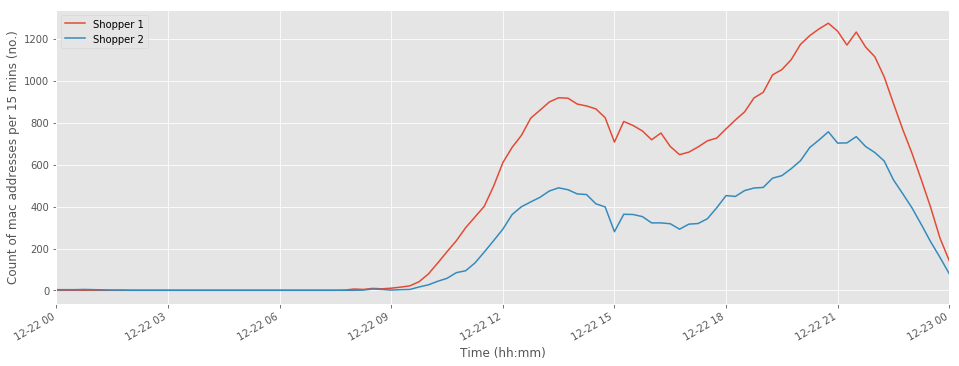

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))



plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper1)], 
    axes=ax,
    label='Shopper 1',
);



plot_histogram_jn(
    signal_df[signal_df.mac_address.isin(shopper2)], 
    axes=ax,
    label='Shopper 2',
);

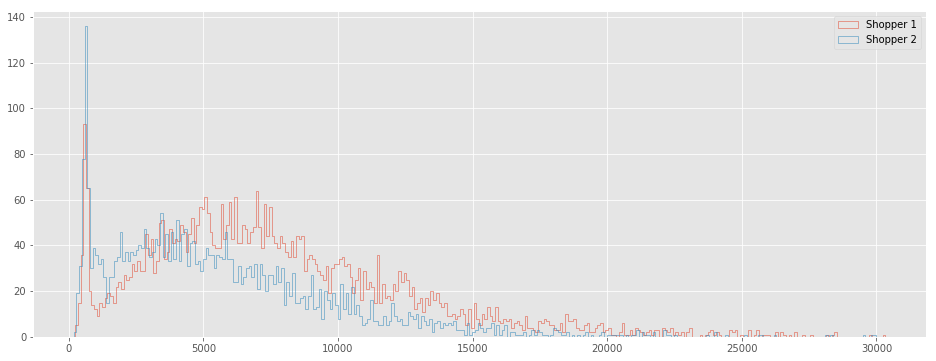

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 100

data = shopper_df[shopper_df.mac_address.isin(shopper1)].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1')

data = shopper_df[shopper_df.mac_address.isin(shopper2)].length_of_stay
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 2')

ax.legend();

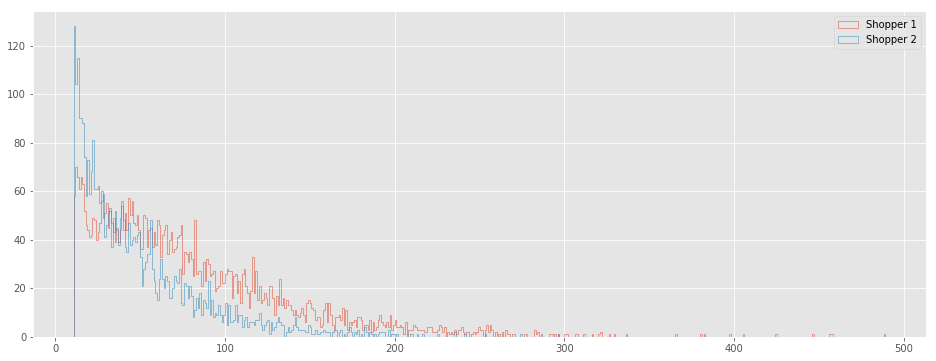

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df[shopper_df.mac_address.isin(shopper1)].frequency
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1')

data = shopper_df[shopper_df.mac_address.isin(shopper2)].frequency
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 2')

ax.legend();

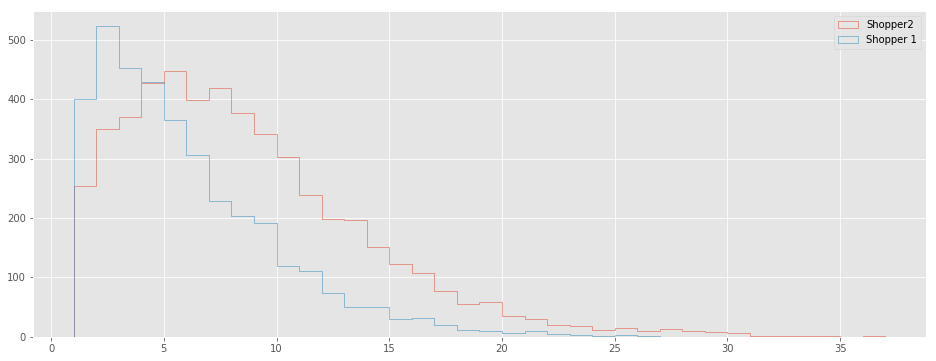

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 6))

binwidth = 1

data = shopper_df[shopper_df.mac_address.isin(shopper1)].number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper2');

data = shopper_df[shopper_df.mac_address.isin(shopper2)].number_of_shops.as_matrix()
ax.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth), histtype='step', label='Shopper 1');

ax.legend();

In [19]:
FEATURE_LIST = [
    'length_of_stay',
    'radius_of_gyration',
    'count_density_variance',
    'av_speed',
    'av_turning_angle',
    'av_path_length',
    'av_straightness',
    'turning_angle_density',
]

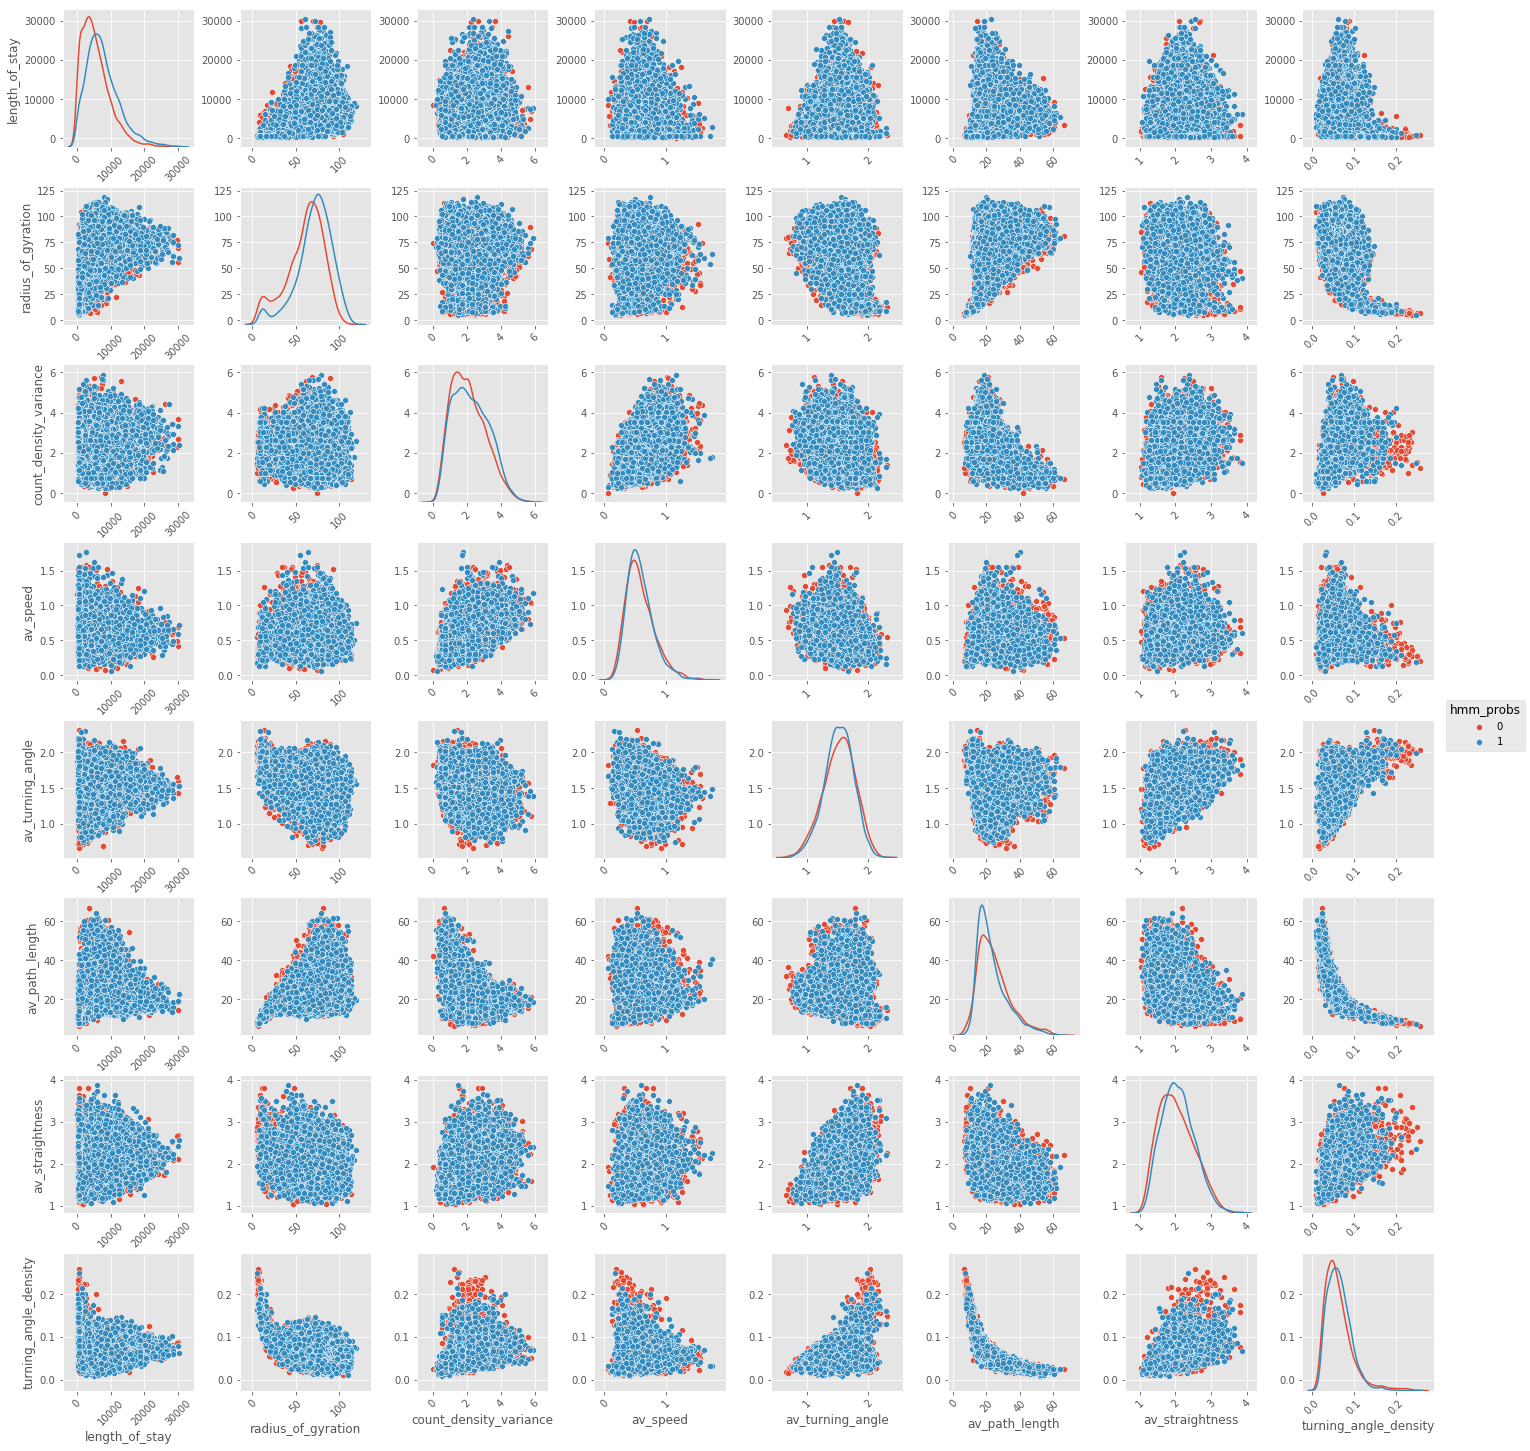

In [20]:
g = sns.pairplot(
    shopper_in_signal_df,
    vars=FEATURE_LIST,
    hue="hmm_probs", diag_kind="kde", dropna=True
)
 
for ax in g.axes.flat: 
    plt.setp(ax.get_xticklabels(), rotation=45)

## Maps

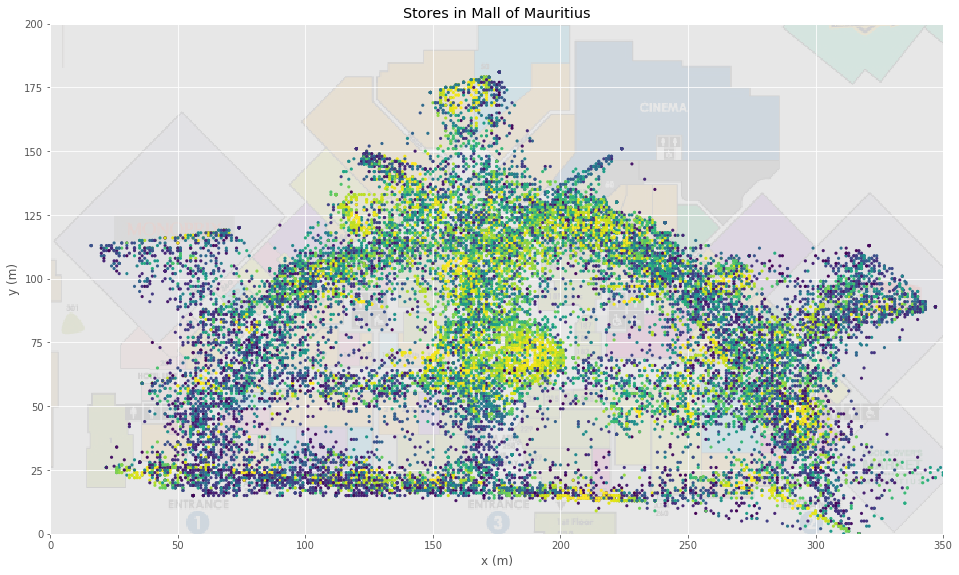

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    shopper1[:100],
    axes=ax, 
    plot_type='density', 
    label=False
)

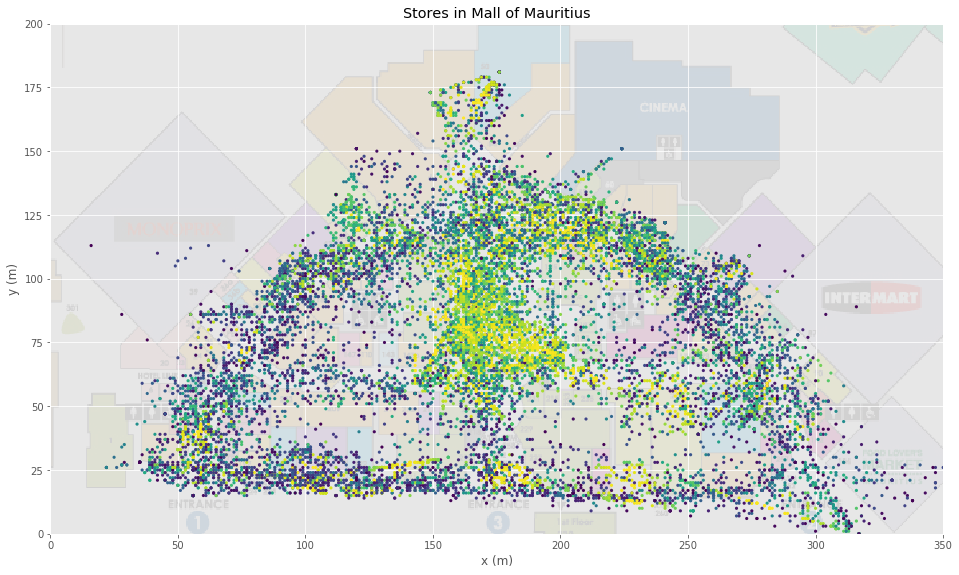

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

plot_path_jn(
    signal_df, 
    shopper2[:100],
    axes=ax, 
    plot_type='density', 
    label=False
)

## Shops visited

In [23]:
number_of_shop = 10

shop_index = model.emissionprob_[0].argsort()[-number_of_shop:][::-1]
shops1 = le.inverse_transform(shop_index)

shop_index = model.emissionprob_[1].argsort()[-number_of_shop:][::-1]
shops2 = le.inverse_transform(shop_index)

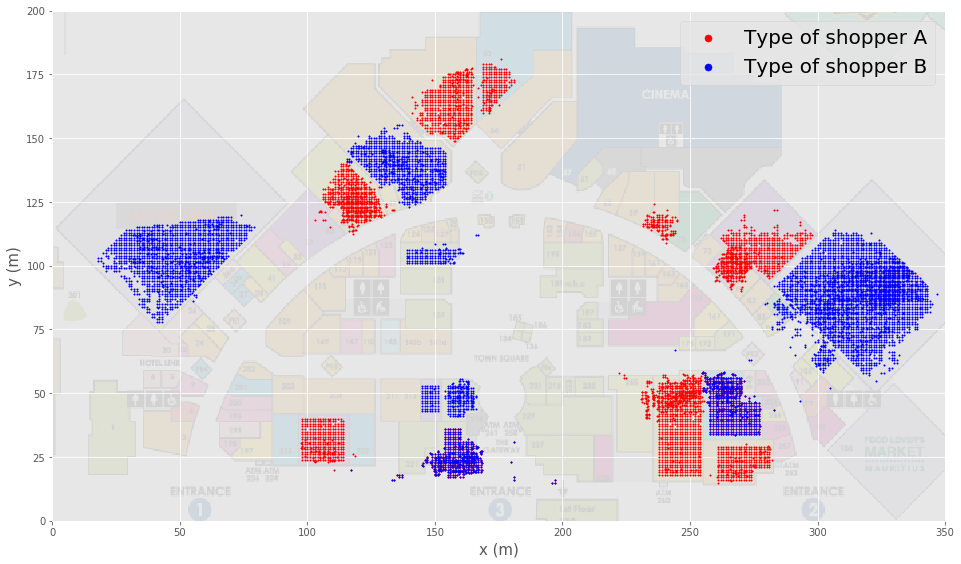

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 10))

x = signal_df[signal_df.store_id.isin(shops1)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 0]
y = signal_df[signal_df.store_id.isin(shops1)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 1]
plot_points_on_map_jn(x, y, axes=ax, c='r', label='Type of shopper A')

x = signal_df[signal_df.store_id.isin(shops2)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 0]
y = signal_df[signal_df.store_id.isin(shops2)].drop_duplicates(['x', 'y'])[['x', 'y']].as_matrix()[:, 1]
plot_points_on_map_jn(x, y, axes=ax, c='b', label='Type of shopper B')

ax.legend(markerscale=5., fontsize=20)

# fig.savefig('hmm_shopper_cluster_map.png', format='png', transparent=True, dpi=500)